In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

In [2]:
def test_k_min_indices_no_overlap():
    width, height, num_Z = 5, 5, 20
    k = 3
    gss_window = 2
    
    # Create random loss values and sort them to get indices
    np.random.seed(0)
    all_losses = np.random.rand(width, height, num_Z)
    sorted_indices = np.argsort(all_losses, axis=2)
    print(sorted_indices[0,0,:])
    
    k_min_indices = section_search.k_min_indices_no_overlap(sorted_indices, k=k, gss_window=gss_window)
    
    assert k_min_indices.shape == (width, height, k)
    assert np.all(k_min_indices >= 0)
    
    for i in range(width):
        for j in range(height):
            values = np.sort(k_min_indices[i, j])
            for a in range(len(values)):
                for b in range(a+1, len(values)):
                    assert abs(values[a] - values[b]) >= gss_window, \
                        f"Overlap violation at ({i},{j}): {values}"
    
    
    print("Sample indices at (0,0):", k_min_indices[0, 0])
    print("Corresponding loss values:", all_losses[0, 0][k_min_indices[0, 0]])

test_k_min_indices_no_overlap()

[16 14 15  9  4  6 11  3  0 12  2  5  1 18 10 17 19  7 13  8]
Sample indices at (0,0): [16  9  4]
Corresponding loss values: [0.0202184  0.38344152 0.4236548 ]


cuda
[0.4862745  0.38431373 0.3254902 ]


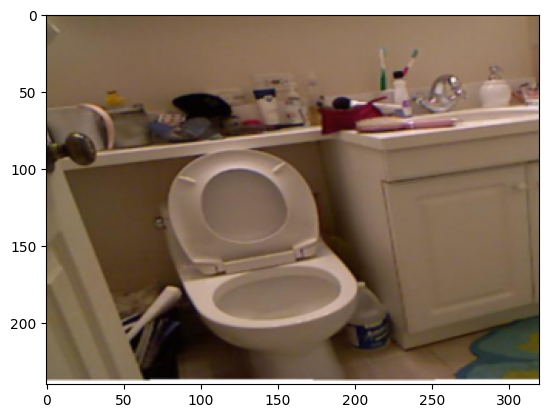

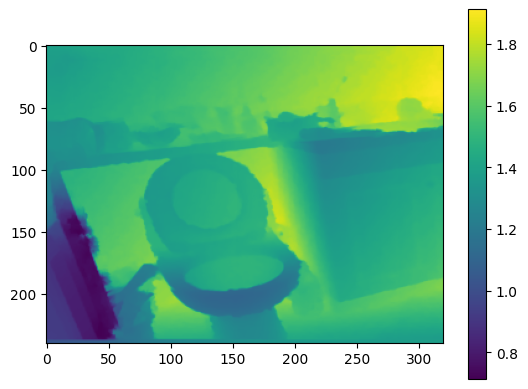

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007330422..1.0363318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009103271..1.007969].


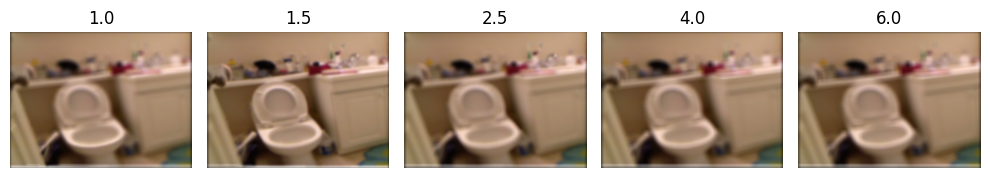

In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



In [7]:
# # test -- can the PGD reconstruct the ground truth AIF from the ground truth depth map?

# recon_aif = least_squares.bounded_fista(gt_dpt, defocus_stack, IMAGE_RANGE, maxiter=2000, gt=gt_aif)


# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

In [11]:
dpt = torch.ones((width, height)) * 0.3
Df_expanded = globals.Df.view(1, 1, -1).to(dpt.device)
CoC = ((globals.D) 
        * (torch.abs(dpt.unsqueeze(-1) - Df_expanded) / (dpt.unsqueeze(-1)+1e-8)) 
        * (globals.f / (Df_expanded - globals.f)))
    
r = CoC / 2. / globals.ps
print(r.min())

tensor(31.9810)


In [8]:
# recon_aif = least_squares.least_squares(gt_dpt, defocus_stack, maxiter = 500)
# utils.plot_compare_rgb(gt_aif, recon_aif)
# plt.show()

# print(torch.mean((gt_aif - recon_aif)**2).item())

(240, 320, 5)


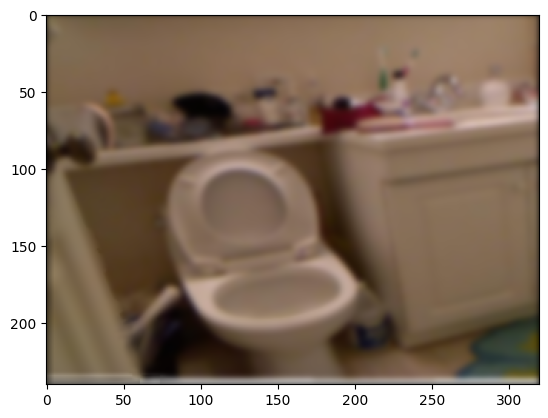

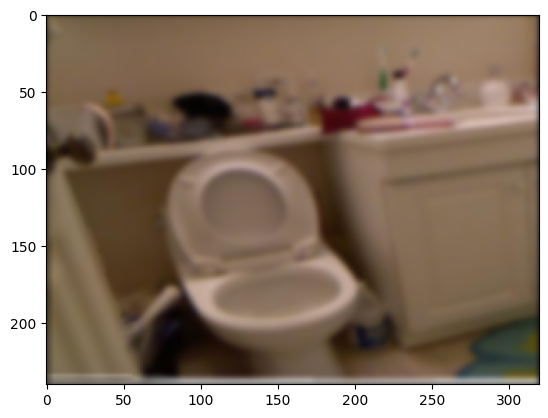

In [9]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [10]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init, 
                                                 aif_method='fista', finite_differences=False,
                                                    k=3,
                                                num_Z=100, ls_maxiter=200, ls_maxiter_multiplier=1.05,#1.075, 
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


Created experiment folder: experiments/coord-descent_2025-08-11_12-46-57
Images in range [0-255]
Iteration 0 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04862104]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.048621040004243415.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04862104]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 8.279793977737427


Optimizing: 100%|█████████████████████████████| 200/200 [01:44<00:00,  1.92it/s]


r1norm 3822.964252392077 norm(x) 52638.62660042771

AIF result range: [ 0.0 , 255.0 ]
Loss: 12.686667442321777 , TV: 5142134.917222953
Loss after clipping: 12.686667442321777 , TV: 5142134.917222953



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.20it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.4008163663589563 , TV: 69476.02304865957

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 210


--------------------------

Iteration 1 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0249209]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.02492090285530191.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0249209]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.555695295333862


Optimizing: 100%|█████████████████████████████| 210/210 [01:18<00:00,  2.68it/s]


r1norm 873.3679504786579 norm(x) 51852.607812971015

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.6621254093972894 , TV: 4408851.487721683
Loss after clipping: 0.6621254093972894 , TV: 4408851.487721683



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.59it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.28026201295358094 , TV: 33019.71791759164

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 220


--------------------------

Iteration 2 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04192764]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.041927640638664.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04192764]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.965314149856567


Optimizing: 100%|█████████████████████████████| 220/220 [01:23<00:00,  2.63it/s]


r1norm 317.47566171648316 norm(x) 51652.956917506664

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.08749122235484044 , TV: 2722434.760960289
Loss after clipping: 0.08749122235484044 , TV: 2722434.760960289



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.55it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.03954954429379213 , TV: 11279.840586390732

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 231


--------------------------

Iteration 3 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04833549]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.048101486330013835.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04810149]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.250274181365967


Optimizing: 100%|█████████████████████████████| 231/231 [01:26<00:00,  2.66it/s]


r1norm 115.98932291145609 norm(x) 51609.210610166134

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.011678006448754078 , TV: 2160401.7385998513
Loss after clipping: 0.011678006448754078 , TV: 2160401.7385998513



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.004961162561984272 , TV: 3709.8772943598347

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 242


--------------------------

Iteration 4 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02538344]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.025383439737777357.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02538344]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.947679758071899


Optimizing: 100%|█████████████████████████████| 242/242 [01:32<00:00,  2.63it/s]


r1norm 42.76961597637694 norm(x) 51602.70961283641

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0015875963816519402 , TV: 2025202.0441224375
Loss after clipping: 0.0015875963816519402 , TV: 2025202.0441224375



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.53it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0008163885530372086 , TV: 1883.5953604375777

DPT result range: [ 0.10172209268743165 , 5.66606064612543 ]


ls_maxiter updated to 254


--------------------------

Iteration 5 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05384113]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05384113426864591.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05384113]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.306804656982422


Optimizing: 100%|█████████████████████████████| 254/254 [01:35<00:00,  2.67it/s]


r1norm 24.910510162258966 norm(x) 51602.93996967916

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0005384144918349643 , TV: 2005596.6748982964
Loss after clipping: 0.0005384144918349643 , TV: 2005596.6748982964



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00047504405113470393 , TV: 1676.4738807028793

DPT result range: [ 0.10172209268743165 , 7.18672575837461 ]


ls_maxiter updated to 266


--------------------------

Iteration 6 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03577911]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03577911345437312.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03577911]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.54131293296814


Optimizing: 100%|█████████████████████████████| 266/266 [01:40<00:00,  2.66it/s]


r1norm 21.96318684037563 norm(x) 51603.55838363567

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0004185261315190441 , TV: 2003442.263658799
Loss after clipping: 0.0004185261315190441 , TV: 2003442.263658799



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.65it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0004000511597630552 , TV: 1613.1277841205601

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 279


--------------------------

Iteration 7 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02249713]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.022497132072711343.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02249713]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.94492769241333


Optimizing: 100%|█████████████████████████████| 279/279 [01:43<00:00,  2.70it/s]


r1norm 20.64310364661641 norm(x) 51604.2380671484

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00036973488822326966 , TV: 2002785.711824874
Loss after clipping: 0.00036973488822326966 , TV: 2002785.711824874



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.64it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003619969538291217 , TV: 1538.2513588293173

DPT result range: [ 0.10172209268743165 , 4.18672575837461 ]


ls_maxiter updated to 292


--------------------------

Iteration 8 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03498986]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03498985979597954.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03498986]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.111789226531982


Optimizing: 100%|█████████████████████████████| 292/292 [01:48<00:00,  2.69it/s]


r1norm 19.78851691938825 norm(x) 51604.934152181486

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00033977185210266615 , TV: 2002682.1240993603
Loss after clipping: 0.00033977185210266615 , TV: 2002682.1240993603



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.66it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003350225503872761 , TV: 1512.1782178745696

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 306


--------------------------

Iteration 9 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04343579]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04343578973784396.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04343579]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.407874584197998


Optimizing: 100%|█████████████████████████████| 306/306 [01:54<00:00,  2.67it/s]


r1norm 19.073665051909067 norm(x) 51605.731787642646

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0003156825574123169 , TV: 2002859.5695998815
Loss after clipping: 0.0003156825574123169 , TV: 2002859.5695998815



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.70it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0003114468526162536 , TV: 1433.7868698608004

DPT result range: [ 0.10172209268743165 , 4.23819660112501 ]


ls_maxiter updated to 321


--------------------------

Iteration 10 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04788479]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.043757925295711125.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04375793]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.522475242614746


Optimizing: 100%|█████████████████████████████| 321/321 [02:00<00:00,  2.67it/s]


r1norm 18.388192251695344 norm(x) 51606.655746966535

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002934107724746163 , TV: 2003288.2383827048
Loss after clipping: 0.0002934107724746163 , TV: 2003288.2383827048



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.57it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00029132084451242 , TV: 1391.9827699373682

DPT result range: [ 0.10172209268743165 , 2.2549150281252635 ]


ls_maxiter updated to 337


--------------------------

Iteration 11 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05072014]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05072013628571368.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05072014]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.322922468185425


Optimizing: 100%|█████████████████████████████| 337/337 [02:08<00:00,  2.63it/s]


r1norm 17.818027196072034 norm(x) 51607.59070140152

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00027551130788411814 , TV: 2003898.1459163688
Loss after clipping: 0.00027551130788411814 , TV: 2003898.1459163688



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.59it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002736497826583428 , TV: 1357.942940601796

DPT result range: [ 0.10172209268743165 , 2.3339393538745687 ]


ls_maxiter updated to 353


--------------------------

Iteration 12 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03237063]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03237062744358126.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03237063]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.5085060596466064


Optimizing: 100%|█████████████████████████████| 353/353 [02:10<00:00,  2.71it/s]


r1norm 17.357991456841734 norm(x) 51608.39760857115

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002614774327213437 , TV: 2004479.52878043
Loss after clipping: 0.0002614774327213437 , TV: 2004479.52878043



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.50it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0002596132506895363 , TV: 1336.6870938876662

DPT result range: [ 0.10172209268743165 , 2.3270509831248427 ]


ls_maxiter updated to 370


--------------------------

Iteration 13 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03820621]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.03599906369317292.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03599906]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.1761393547058105


Optimizing: 100%|█████████████████████████████| 370/370 [02:20<00:00,  2.64it/s]


r1norm 16.92640831521972 norm(x) 51609.210397191804

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002486462600532451 , TV: 2004954.875981133
Loss after clipping: 0.0002486462600532451 , TV: 2004954.875981133



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.75it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00024721804286783044 , TV: 1302.5074311308865

DPT result range: [ 0.10172209268743165 , 2.3132742416253897 ]


ls_maxiter updated to 388


--------------------------

Iteration 14 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03419041]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.034190408059276894.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03419041]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.103721618652344


Optimizing: 100%|█████████████████████████████| 388/388 [02:29<00:00,  2.60it/s]


r1norm 16.58536383635667 norm(x) 51609.92759194431

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00023873379219083575 , TV: 2005057.869991959
Loss after clipping: 0.00023873379219083575 , TV: 2005057.869991959



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.85it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00023775885302477527 , TV: 1279.590570162034

DPT result range: [ 0.10172209268743165 , 2.324419859625558 ]


ls_maxiter updated to 407


--------------------------

Iteration 15 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04973158]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.04963800168572381.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.049638]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.883349418640137


Optimizing: 100%|█████████████████████████████| 407/407 [02:35<00:00,  2.62it/s]


r1norm 16.287697807740898 norm(x) 51610.59439860873

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00023024555053750224 , TV: 2005156.6442505005
Loss after clipping: 0.00023024555053750224 , TV: 2005156.6442505005



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.81it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00022972612776974926 , TV: 1256.6457035708163

DPT result range: [ 0.10172209268743165 , 2.0686917696247162 ]


ls_maxiter updated to 427


--------------------------

Iteration 16 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03863058]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03863058285486676.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03863058]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.299909830093384


Optimizing: 100%|█████████████████████████████| 427/427 [02:40<00:00,  2.65it/s]


r1norm 16.004566673287474 norm(x) 51611.21872720053

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00022231727908038896 , TV: 2004879.143783927
Loss after clipping: 0.00022231727908038896 , TV: 2004879.143783927



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.74it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00022190799126662136 , TV: 1236.6861021093102

DPT result range: [ 0.10172209268743165 , 2.090983005625053 ]


ls_maxiter updated to 448


--------------------------

Iteration 17 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04611219]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.046112189023557924.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04611219]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.260920286178589


Optimizing: 100%|█████████████████████████████| 448/448 [02:46<00:00,  2.69it/s]


r1norm 15.77295023285367 norm(x) 51611.76480736145

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00021593433236886996 , TV: 2004458.6779761538
Loss after clipping: 0.00021593433236886996 , TV: 2004458.6779761538



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.60it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00021546052727778548 , TV: 1217.138599344471

DPT result range: [ 0.10172209268743165 , 2.0755801403744423 ]


ls_maxiter updated to 470


--------------------------

Iteration 18 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0390789]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03907890462916595.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0390789]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.207839488983154


Optimizing: 100%|█████████████████████████████| 470/470 [02:54<00:00,  2.70it/s]


r1norm 15.569340481397738 norm(x) 51612.20564570187

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00021039931881390117 , TV: 2003824.8592547746
Loss after clipping: 0.00021039931881390117 , TV: 2003824.8592547746



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.69it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.000210101164451742 , TV: 1195.8665540102422

DPT result range: [ 0.10172209268743165 , 1.9313082303752838 ]


ls_maxiter updated to 493


--------------------------

Iteration 19 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03483221]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03483221035299128.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03483221]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.473821401596069


Optimizing: 100%|█████████████████████████████| 493/493 [02:58<00:00,  2.76it/s]


r1norm 15.414202217942986 norm(x) 51612.565193566705

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0002062294665739883 , TV: 2003024.7808199627
Loss after clipping: 0.0002062294665739883 , TV: 2003024.7808199627



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.52it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020588161950230722 , TV: 1174.8100021620346

DPT result range: [ 0.5381966011250104 , 1.9326237921249265 ]


ls_maxiter updated to 517


--------------------------

Iteration 20 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04266989]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.042669890344073716.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04266989]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.235612154006958


Optimizing: 100%|█████████████████████████████| 517/517 [03:06<00:00,  2.77it/s]


r1norm 15.264485498724289 norm(x) 51613.0162292503

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00020224581533507567 , TV: 2002203.9883663938
Loss after clipping: 0.00020224581533507567 , TV: 2002203.9883663938



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.80it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00020202976226168094 , TV: 1157.7916016045667

DPT result range: [ 0.6339393538745689 , 1.915905365124674 ]


ls_maxiter updated to 542


--------------------------

Iteration 21 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05379495]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.053794954269767964.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05379495]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.434683322906494


Optimizing: 100%|█████████████████████████████| 542/542 [03:16<00:00,  2.76it/s]


r1norm 15.131966026319768 norm(x) 51613.529255472626

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001987515524746017 , TV: 2001539.077528047
Loss after clipping: 0.0001987515524746017 , TV: 2001539.077528047



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.61it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019853747648743608 , TV: 1148.403514974057

DPT result range: [ 0.6201626123751157 , 1.915905365124674 ]


ls_maxiter updated to 569


--------------------------

Iteration 22 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04011218]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.040112176139969445.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04011218]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.204673767089844


Optimizing: 100%|█████████████████████████████| 569/569 [03:33<00:00,  2.67it/s]


r1norm 14.998670540346492 norm(x) 51614.09167354062

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00019526763011114745 , TV: 2001132.3347391835
Loss after clipping: 0.00019526763011114745 , TV: 2001132.3347391835



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.79it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019503943150601157 , TV: 1133.967628238099

DPT result range: [ 0.6313082303752839 , 1.9270509831248424 ]


ls_maxiter updated to 597


--------------------------

Iteration 23 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06431085]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.06431085085067303.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06431085]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.9637415409088135


Optimizing: 100%|█████████████████████████████| 597/597 [03:41<00:00,  2.70it/s]


r1norm 14.882003966469531 norm(x) 51614.60293597786

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00019224358598399812 , TV: 2000769.8660713024
Loss after clipping: 0.00019224358598399812 , TV: 2000769.8660713024



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.72it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00019209883973768597 , TV: 1126.5649838932075

DPT result range: [ 0.684094634875326 , 1.9549150281252627 ]


ls_maxiter updated to 626


--------------------------

Iteration 24 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06825679]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.06825678921619487.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06825679]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.641564846038818


Optimizing: 100%|█████████████████████████████| 626/626 [03:47<00:00,  2.75it/s]


r1norm 14.79276953114522 norm(x) 51615.05460765568

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018994598678970508 , TV: 2000351.6569462456
Loss after clipping: 0.00018994598678970508 , TV: 2000351.6569462456



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.70it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018983350604415893 , TV: 1119.8456862637895

DPT result range: [ 0.7047597471245057 , 1.9493422191251788 ]


ls_maxiter updated to 657


--------------------------

Iteration 25 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03945001]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03945001332917133.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03945001]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.181582689285278


Optimizing: 100%|█████████████████████████████| 657/657 [03:59<00:00,  2.74it/s]


r1norm 14.708891545427251 norm(x) 51615.43536529719

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001877992989771077 , TV: 1999895.6576965046
Loss after clipping: 0.0001877992989771077 , TV: 1999895.6576965046



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018770414485026133 , TV: 1110.3050636984299

DPT result range: [ 0.6978713763747793 , 1.9201626123751159 ]


ls_maxiter updated to 689


--------------------------

Iteration 26 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04658179]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.046581794671465275.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04658179]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.525752544403076


Optimizing: 100%|█████████████████████████████| 689/689 [04:13<00:00,  2.72it/s]


r1norm 14.630669070198351 norm(x) 51615.74220986766

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001858081699962142 , TV: 1999429.1325245323
Loss after clipping: 0.0001858081699962142 , TV: 1999429.1325245323



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.66it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018568819103104378 , TV: 1104.937478245655

DPT result range: [ 0.6798373876248843 , 1.9313082303752838 ]


ls_maxiter updated to 723


--------------------------

Iteration 27 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06219499]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0621949856207079.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06219499]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.390251159667969


Optimizing: 100%|█████████████████████████████| 723/723 [04:23<00:00,  2.75it/s]


r1norm 14.56336012601617 norm(x) 51615.99335232984

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018410325976114152 , TV: 1999221.8080375018
Loss after clipping: 0.00018410325976114152 , TV: 1999221.8080375018



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.60it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018401803895931932 , TV: 1096.4518109686837

DPT result range: [ 0.713274241625389 , 1.9339393538745688 ]


ls_maxiter updated to 759


--------------------------

Iteration 28 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05567645]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.05288650507648059.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05288651]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.682541131973267


Optimizing: 100%|█████████████████████████████| 759/759 [04:38<00:00,  2.73it/s]


r1norm 14.503936059826703 norm(x) 51616.25389534721

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001826045748514761 , TV: 1999436.071505663
Loss after clipping: 0.0001826045748514761 , TV: 1999436.071505663



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.51it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018253618847318854 , TV: 1089.548998603643

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 796


--------------------------

Iteration 29 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02818656]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.02818655822611366.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02818656]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.19832706451416


Optimizing: 100%|█████████████████████████████| 796/796 [04:52<00:00,  2.72it/s]


r1norm 14.453974148205461 norm(x) 51616.547321804115

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018134910487238476 , TV: 2000063.3086818047
Loss after clipping: 0.00018134910487238476 , TV: 2000063.3086818047



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.58it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001812904556676405 , TV: 1086.6661009063882

DPT result range: [ 0.713274241625389 , 1.9201626123751159 ]


ls_maxiter updated to 835


--------------------------

Iteration 30 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03792255]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03792255458369003.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03792255]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.185505628585815


Optimizing: 100%|█████████████████████████████| 835/835 [05:06<00:00,  2.73it/s]


r1norm 14.404883040039632 norm(x) 51616.84156080308

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00018012000844391666 , TV: 2000797.5328620428
Loss after clipping: 0.00018012000844391666 , TV: 2000797.5328620428



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00018007532091397188 , TV: 1079.3189046179157

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 876


--------------------------

Iteration 31 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04670031]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.046700306617642046.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04670031]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.2576422691345215


Optimizing: 100%|█████████████████████████████| 876/876 [05:19<00:00,  2.75it/s]


r1norm 14.368762047773458 norm(x) 51617.04801059053

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017921809816492004 , TV: 2001760.1199813823
Loss after clipping: 0.00017921809816492004 , TV: 2001760.1199813823



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.73it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001791659704666292 , TV: 1074.1789846615725

DPT result range: [ 0.713274241625389 , 1.9575461516245478 ]


ls_maxiter updated to 919


--------------------------

Iteration 32 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02634379]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.026343791817525407.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02634379]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.61910080909729


Optimizing: 100%|█████████████████████████████| 919/919 [05:36<00:00,  2.73it/s]


r1norm 14.34079579328288 norm(x) 51617.24324891045

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001785214237948531 , TV: 2003015.07820305
Loss after clipping: 0.0001785214237948531 , TV: 2003015.07820305



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.62it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017848343424731972 , TV: 1072.3298863014013

DPT result range: [ 0.713274241625389 , 1.9506577808748213 ]


ls_maxiter updated to 964


--------------------------

Iteration 33 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04291345]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.042913446601913735.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04291345]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.620121479034424


Optimizing: 100%|█████████████████████████████| 964/964 [05:50<00:00,  2.75it/s]


r1norm 14.313410465934954 norm(x) 51617.50307821246

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017784054261331755 , TV: 2004534.1109929716
Loss after clipping: 0.00017784054261331755 , TV: 2004534.1109929716



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.81it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017778997274614094 , TV: 1067.0967600094023

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 1012


--------------------------

Iteration 34 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04387595]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04387594644285882.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04387595]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.466981887817383


Optimizing: 100%|███████████████████████████| 1012/1012 [06:09<00:00,  2.74it/s]


r1norm 14.287681882910071 norm(x) 51617.85377112623

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017720197727798194 , TV: 2006200.6764632014
Loss after clipping: 0.00017720197727798194 , TV: 2006200.6764632014



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.69it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017717391886016957 , TV: 1065.1228126034753

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 1062


--------------------------

Iteration 35 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02541733]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 20 instead with accuracy 
0.025220721300240195.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02522072]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.3614723682403564


Optimizing: 100%|███████████████████████████| 1062/1062 [06:31<00:00,  2.71it/s]


r1norm 14.264468065910092 norm(x) 51618.16793172763

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017662682087984631 , TV: 2007501.2910539247
Loss after clipping: 0.00017662682087984631 , TV: 2007501.2910539247



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.68it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001766027057823884 , TV: 1061.0018369292245

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 1115


--------------------------

Iteration 36 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03529839]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.035298394073395564.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03529839]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.401114225387573


Optimizing: 100%|███████████████████████████| 1115/1115 [06:57<00:00,  2.67it/s]


r1norm 14.244619771765043 norm(x) 51618.44852998469

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017613575153023768 , TV: 2008555.5073073586
Loss after clipping: 0.00017613575153023768 , TV: 2008555.5073073586



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.68it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.0001761134931731479 , TV: 1058.8106792927542

DPT result range: [ 0.713274241625389 , 1.9132742416253892 ]


ls_maxiter updated to 1170


--------------------------

Iteration 37 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04274881]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04274881326279702.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04274881]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.587276220321655


Optimizing: 100%|███████████████████████████| 1170/1170 [07:30<00:00,  2.60it/s]


r1norm 14.224952956051343 norm(x) 51618.67315747801

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.0001756498558337016 , TV: 2009651.6674377606
Loss after clipping: 0.0001756498558337016 , TV: 2009651.6674377606



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.60it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017563417784904957 , TV: 1056.3701728264623

DPT result range: [ 0.713274241625389 , 1.915905365124674 ]


ls_maxiter updated to 1228


--------------------------

Iteration 38 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.07674258]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.07674257919172224.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.07674258]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.142878532409668


Optimizing: 100%|███████████████████████████| 1228/1228 [07:45<00:00,  2.64it/s]


r1norm 14.207025008421576 norm(x) 51618.89420590991

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017520748584227297 , TV: 2010967.9687344912
Loss after clipping: 0.00017520748584227297 , TV: 2010967.9687344912



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.77it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017519324956480358 , TV: 1054.1639788934592

DPT result range: [ 0.713274241625389 , 1.9132742416253892 ]


ls_maxiter updated to 1289


--------------------------

Iteration 39 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0336061]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.033606104644694594.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0336061]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.959904670715332


Optimizing: 100%|███████████████████████████| 1289/1289 [07:55<00:00,  2.71it/s]


r1norm 14.191600346395147 norm(x) 51619.148914876816

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.00017482732479371342 , TV: 2012468.3131872425
Loss after clipping: 0.00017482732479371342 , TV: 2012468.3131872425



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.72it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.00017481561272318018 , TV: 1050.9975969890013

DPT result range: [ 0.713274241625389 , 1.9132742416253892 ]


ls_maxiter updated to 1353


--------------------------



In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]